In [1]:
import tensorflow as tf
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth= True
sess= tf.compat.v1.Session(config=config)
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory( 
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch ,label_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(label_batch)
    

(256, 256, 3)
tf.Tensor([1 1 1 1 1 2 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 2 1 0 0 0 0 1 0], shape=(32,), dtype=int32)


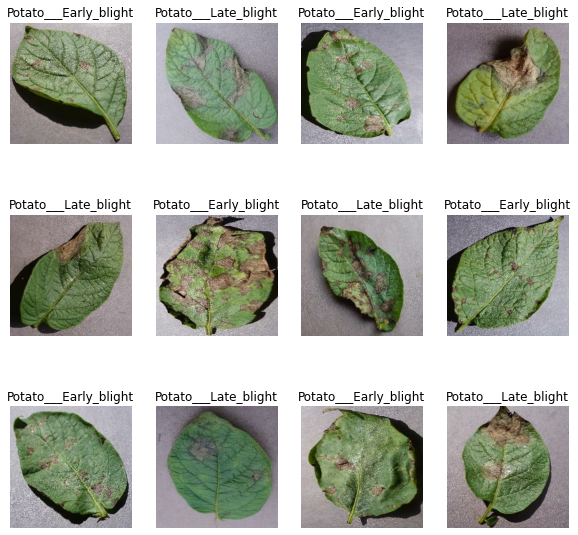

In [8]:
plt.figure(figsize=(10,10))
for image_batch ,label_batch in dataset.take(1):
    
    for i in range(12):
        plt.subplot(3,4,i+1)
        
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

80% data f0r trainning

20% data test( 10% validation 10% test)

In [9]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_split=.1
len(dataset)*val_split

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)

In [14]:
# creating a generic code for all above codes

def get_dataset_partition(
    ds,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    shuffle=True,
    shuffle_size=10000
):
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size= int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    train_ds= ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds,val_ds, test_ds=get_dataset_partition(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [16]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# preprocssing

In [22]:
resize_and_rescale=  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")
    
    
])
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [27]:
history= model.fit(train_ds,
                  epochs=30,
                  batch_size=BATCH_SIZE,
                  verbose=1,
                  validation_data=val_ds)

Epoch 1/30
54/54 [==============================] - 24s 146ms/step - loss: 0.9215 - accuracy: 0.4647 - val_loss: 0.8403 - val_accuracy: 0.4583
Epoch 2/30
54/54 [==============================] - 6s 103ms/step - loss: 0.7381 - accuracy: 0.6400 - val_loss: 0.4901 - val_accuracy: 0.8281
Epoch 3/30
54/54 [==============================] - 6s 103ms/step - loss: 0.4679 - accuracy: 0.8102 - val_loss: 0.3889 - val_accuracy: 0.8594
Epoch 4/30
54/54 [==============================] - 5s 102ms/step - loss: 0.3540 - accuracy: 0.8594 - val_loss: 0.7025 - val_accuracy: 0.7188
Epoch 5/30
54/54 [==============================] - 6s 102ms/step - loss: 0.2851 - accuracy: 0.8941 - val_loss: 0.1690 - val_accuracy: 0.9219
Epoch 6/30
54/54 [==============================] - 6s 103ms/step - loss: 0.1663 - accuracy: 0.9363 - val_loss: 0.2976 - val_accuracy: 0.8750
Epoch 7/30
54/54 [==============================] - 6s 102ms/step - loss: 0.1213 - accuracy: 0.9606 - val_loss: 0.4136 - val_accuracy: 0.8229
Epoch

In [28]:
score= model.evaluate(test_ds)

8/8 [==============================] - 2s 90ms/step - loss: 0.0869 - accuracy: 0.9612


In [29]:
score

[0.08690691739320755, 0.9612069129943848]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history['val_loss']

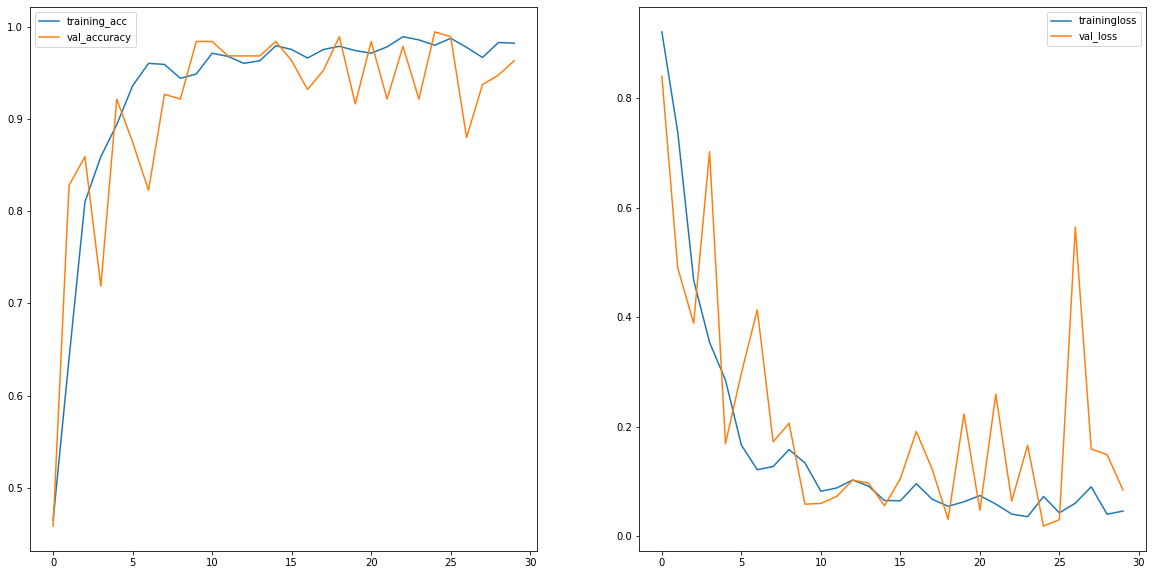

In [34]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(30),acc,label="training_acc")
plt.plot(range(30),val_acc,label="val_accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(30),loss,label="trainingloss")
plt.plot(range(30),val_loss,label="val_loss")

plt.legend()
plt.show()

first image to predict- : Potato___Early_blight
[1.0000000e+00 4.4611190e-11 2.2204685e-22]
predicted label- : Potato___Early_blight


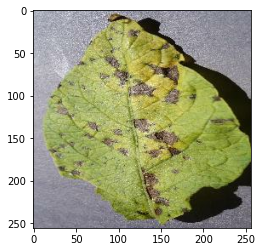

In [35]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    
    print('first image to predict- :',class_name[first_label])
    
    batch_prediction= model.predict(image_batch)
    print(batch_prediction[0])
    predicted_label=class_name[np.argmax(batch_prediction[0])]
    print("predicted label- :",predicted_label)
                                         
    plt.imshow(first_image)

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array= tf.expand_dims(img_array, 0) #creating a batch
    prediction = model.predict(img_array)
    
    predicted_class= class_name[np.argmax(prediction[0])]
    confidence = round(100* (np.max(prediction[0])),2)
    return predicted_class, confidence
    

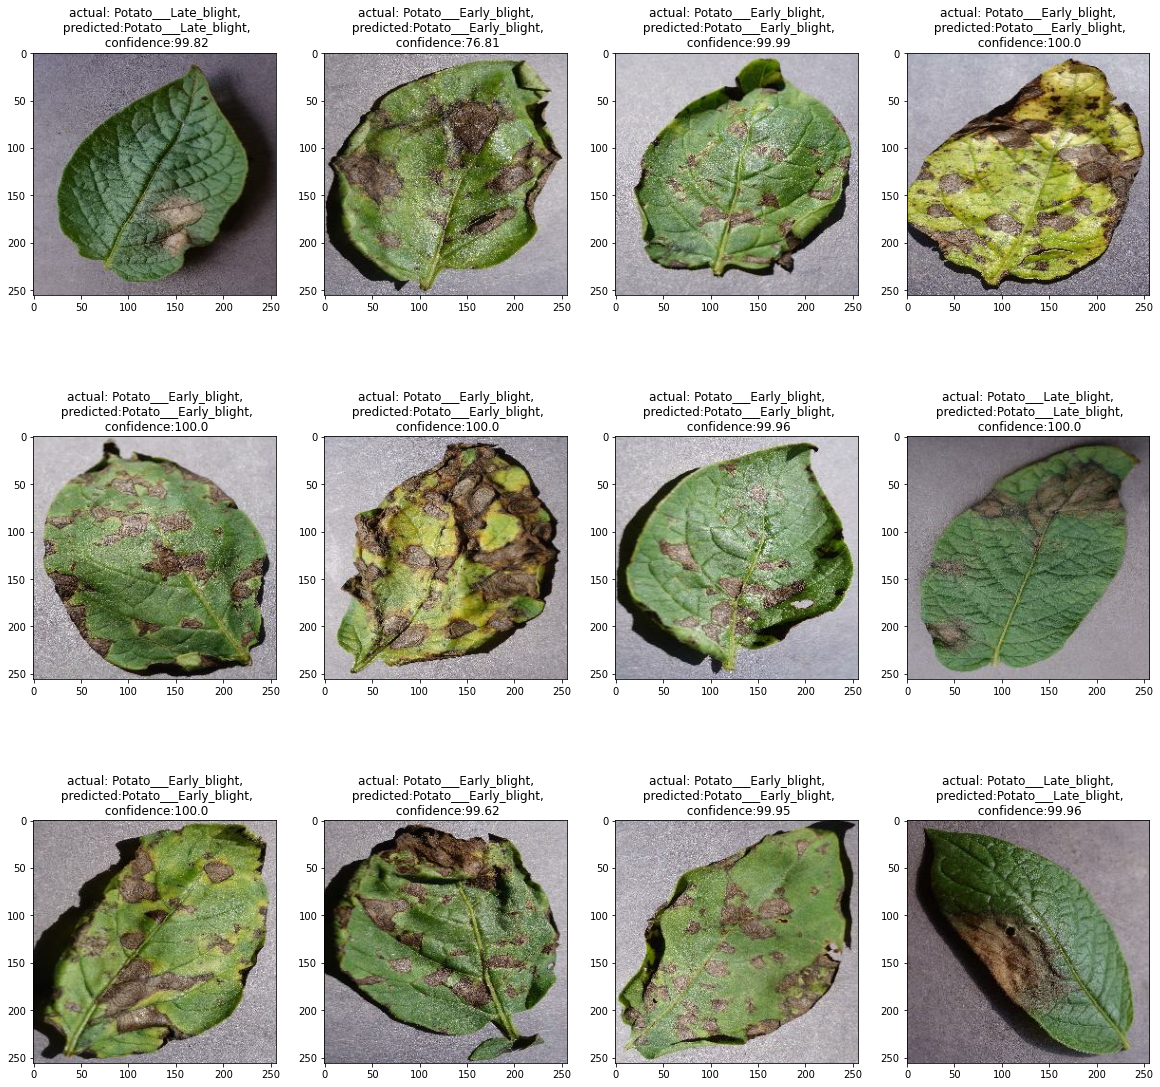

In [37]:
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])
        actual_class= class_name[labels[i]]
        plt.title(f"actual: {actual_class},\n predicted:{predicted_class},\n confidence:{confidence}")
        
            

In [62]:
import os

In [63]:
count=os.listdir("./models")
model_version= len(count)+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


In [38]:
model.save("final_model.h5")

In [40]:
from keras.models import load_model

In [41]:
loaded_model= load_model("final_model.h5")

In [42]:
from keras.preprocessing.image import load_img
# load the image
img = load_img('image.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
img.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(256, 256)


In [46]:
def predict_loaded(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array= tf.expand_dims(img_array, 0) #creating a batch
    prediction = model.predict(img_array)
    
    predicted_class= class_name[np.argmax(prediction[0])]
    confidence = round(100* (np.max(prediction[0])),2)
    return predicted_class, confidence

In [47]:
predict_loaded(loaded_model,img)

('Potato___healthy', 99.93)